# Care Plan Recommendation - Collaborative Filtering Data Preparation

**Objective:** Prepare patient and care plan data for collaborative filtering algorithms to recommend personalized Alzheimer's care plans.

**Data Sources:**
- `alzheimers_disease_data.csv`: Patient health metrics
- `care_plan_recommendations.csv`: Care plan assignments

**Approach:**
1. Load and explore care plan data
2. Merge with patient data (using only Lasso-selected features from prediction model)
3. Encode categorical variables
4. Create user-item interaction matrix
5. Analyze sparsity and distribution
6. Save prepared datasets for collaborative filtering

**Features Used:** Only the 16 features selected by Lasso regression in the prediction notebook for optimal model performance.

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning and preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Care Plan Recommendations

Loading the care plan assignment data to understand what care plans have been assigned to which patients.

In [2]:
# Load care plan recommendations
care_plans = pd.read_csv('data/care_plan_recommendations.csv')

print("=" * 70)
print("CARE PLAN DATA OVERVIEW")
print("=" * 70)
print(f"Total care plans: {len(care_plans)}")
print(f"Unique patients: {care_plans['PatientID'].nunique()}")
print(f"Unique care plan IDs: {care_plans['CarePlanID'].nunique()}")
print(f"\nDataset shape: {care_plans.shape}")
print(f"\nColumns: {care_plans.columns.tolist()}")
print(f"\nRisk Level Distribution:")
print(care_plans['RiskLevel'].value_counts())
print(f"\nPrimary Focus Distribution:")
print(care_plans['PrimaryFocus'].value_counts())

care_plans.head(10)

CARE PLAN DATA OVERVIEW
Total care plans: 2149
Unique patients: 2149
Unique care plan IDs: 2149

Dataset shape: (2149, 10)

Columns: ['CarePlanID', 'PatientID', 'RiskLevel', 'PrimaryFocus', 'CarePlanType', 'RecommendedActions', 'Frequency', 'AssignedTo', 'MonitoringIndicators', 'ReviewPeriod']

Risk Level Distribution:
HIGH      1628
MEDIUM     269
LOW        252
Name: RiskLevel, dtype: int64

Primary Focus Distribution:
Daily Assistance     866
Cognitive Decline    853
Preventive Care      430
Name: PrimaryFocus, dtype: int64


,CarePlanID,PatientID,RiskLevel,PrimaryFocus,CarePlanType,RecommendedActions,Frequency,AssignedTo,MonitoringIndicators,ReviewPeriod
0,CP4751,4751,HIGH,Daily Assistance,Personalized Alzheimer Care,ADL support; Structured daily routine; Nutriti...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
1,CP4752,4752,HIGH,Daily Assistance,Personalized Alzheimer Care,ADL support; Structured daily routine; Medicat...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
2,CP4753,4753,HIGH,Cognitive Decline,Personalized Alzheimer Care,Memory games; Orientation exercises,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
3,CP4754,4754,HIGH,Cognitive Decline,Personalized Alzheimer Care,Memory games; Orientation exercises; Behaviora...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
4,CP4755,4755,HIGH,Daily Assistance,Personalized Alzheimer Care,Memory games; Orientation exercises; ADL suppo...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
5,CP4756,4756,LOW,Preventive Care,Personalized Alzheimer Care,Nutrition monitoring; Blood glucose tracking,Weekly,Caregiver,"MMSE, ADL, Behavior",Monthly
6,CP4757,4757,HIGH,Cognitive Decline,Personalized Alzheimer Care,Memory games; Orientation exercises; Medicatio...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
7,CP4758,4758,HIGH,Cognitive Decline,Personalized Alzheimer Care,Memory games; Orientation exercises; Medicatio...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
8,CP4759,4759,HIGH,Daily Assistance,Personalized Alzheimer Care,ADL support; Structured daily routine; Blood p...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly
9,CP4760,4760,LOW,Preventive Care,Personalized Alzheimer Care,Behavioral therapy; Calming activities,Weekly,Caregiver,"MMSE, ADL, Behavior",Monthly


## 3. Load Patient Data with Selected Features

Loading patient health data and keeping **only the 16 features** selected by Lasso regression in the prediction model:

**Selected Features:**
1. Age
2. EducationLevel
3. Smoking
4. SleepQuality
5. CardiovascularDisease
6. HeadInjury
7. Hypertension
8. CholesterolLDL
9. CholesterolHDL
10. CholesterolTriglycerides
11. MMSE
12. FunctionalAssessment
13. MemoryComplaints
14. BehavioralProblems
15. ADL
16. Disorientation

*These features were identified as the most predictive in the Alzheimer's disease prediction model.*

In [3]:
# Load full patient dataset
df_full = pd.read_csv('data/alzheimers_disease_data.csv')

# Define the 16 features selected by Lasso (from prediction notebook)
selected_features = [
    'Age', 'EducationLevel', 'Smoking', 'SleepQuality',
    'CardiovascularDisease', 'HeadInjury', 'Hypertension',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'MemoryComplaints',
    'BehavioralProblems', 'ADL', 'Disorientation'
]

# Keep only PatientID, selected features, and Diagnosis
patient_data = df_full[['PatientID'] + selected_features + ['Diagnosis']].copy()

print("=" * 70)
print("PATIENT DATA WITH SELECTED FEATURES")
print("=" * 70)
print(f"Total patients: {len(patient_data)}")
print(f"Features retained: {len(selected_features)}")
print(f"Dataset shape: {patient_data.shape}")
print(f"\nFeatures: {selected_features}")
print(f"\nDiagnosis distribution:")
print(patient_data['Diagnosis'].value_counts())

patient_data.head()

PATIENT DATA WITH SELECTED FEATURES
Total patients: 2149
Features retained: 16
Dataset shape: (2149, 18)

Features: ['Age', 'EducationLevel', 'Smoking', 'SleepQuality', 'CardiovascularDisease', 'HeadInjury', 'Hypertension', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Disorientation']

Diagnosis distribution:
0    1389
1     760
Name: Diagnosis, dtype: int64


,PatientID,Age,EducationLevel,Smoking,SleepQuality,CardiovascularDisease,HeadInjury,Hypertension,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Disorientation,Diagnosis
0,4751,73,2,0,9.025679,0,0,0,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0
1,4752,89,0,0,7.151293,0,0,0,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0
2,4753,73,1,0,9.673574,0,0,0,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,1,0
3,4754,74,1,1,8.392554,0,0,0,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0
4,4755,89,0,0,5.597238,0,0,0,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0


## 4. Merge Patient Features with Care Plans

Combining patient health metrics with assigned care plans to create a unified dataset for collaborative filtering.

In [4]:
# Merge patient features with care plan data
cf_data = care_plans.merge(patient_data, on='PatientID', how='inner')

print("=" * 70)
print("MERGED COLLABORATIVE FILTERING DATASET")
print("=" * 70)
print(f"Total records: {len(cf_data)}")
print(f"Total columns: {len(cf_data.columns)}")
print(f"Patients with care plans: {cf_data['PatientID'].nunique()}")
print(f"Care plans assigned: {cf_data['CarePlanID'].nunique()}")
print(f"\nDataset shape: {cf_data.shape}")
print(f"\nMissing values: {cf_data.isnull().sum().sum()}")

print(f"\nColumns breakdown:")
print(f"  - Care plan metadata: CarePlanID, RiskLevel, PrimaryFocus, CarePlanType, etc.")
print(f"  - Patient features (Lasso-selected): {len(selected_features)} features")
print(f"  - Target: Diagnosis")

cf_data.head()

MERGED COLLABORATIVE FILTERING DATASET
Total records: 2149
Total columns: 27
Patients with care plans: 2149
Care plans assigned: 2149

Dataset shape: (2149, 27)

Missing values: 170

Columns breakdown:
  - Care plan metadata: CarePlanID, RiskLevel, PrimaryFocus, CarePlanType, etc.
  - Patient features (Lasso-selected): 16 features
  - Target: Diagnosis


,CarePlanID,PatientID,RiskLevel,PrimaryFocus,CarePlanType,RecommendedActions,Frequency,AssignedTo,MonitoringIndicators,ReviewPeriod,Age,EducationLevel,Smoking,SleepQuality,CardiovascularDisease,HeadInjury,Hypertension,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Disorientation,Diagnosis
0,CP4751,4751,HIGH,Daily Assistance,Personalized Alzheimer Care,ADL support; Structured daily routine; Nutriti...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly,73,2,0,9.025679,0,0,0,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0
1,CP4752,4752,HIGH,Daily Assistance,Personalized Alzheimer Care,ADL support; Structured daily routine; Medicat...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly,89,0,0,7.151293,0,0,0,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0
2,CP4753,4753,HIGH,Cognitive Decline,Personalized Alzheimer Care,Memory games; Orientation exercises,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly,73,1,0,9.673574,0,0,0,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,1,0
3,CP4754,4754,HIGH,Cognitive Decline,Personalized Alzheimer Care,Memory games; Orientation exercises; Behaviora...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly,74,1,1,8.392554,0,0,0,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0
4,CP4755,4755,HIGH,Daily Assistance,Personalized Alzheimer Care,Memory games; Orientation exercises; ADL suppo...,Daily,Caregiver,"MMSE, ADL, Behavior",Monthly,89,0,0,5.597238,0,0,0,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0


## 5. Encode Categorical Variables

Preparing categorical care plan features for machine learning by encoding them numerically.

In [5]:
# Create a copy for encoding
cf_dataset = cf_data.copy()

# Initialize label encoders
le_risk = LabelEncoder()
le_focus = LabelEncoder()
le_type = LabelEncoder()

# Encode categorical features
cf_dataset['RiskLevel_Encoded'] = le_risk.fit_transform(cf_dataset['RiskLevel'])
cf_dataset['PrimaryFocus_Encoded'] = le_focus.fit_transform(cf_dataset['PrimaryFocus'])
cf_dataset['CarePlanType_Encoded'] = le_type.fit_transform(cf_dataset['CarePlanType'])

# Create interaction column (all records represent patient-care plan assignments)
cf_dataset['Interaction'] = 1

# Store label mappings for interpretation
label_mappings = {
    'RiskLevel': dict(enumerate(le_risk.classes_)),
    'PrimaryFocus': dict(enumerate(le_focus.classes_)),
    'CarePlanType': dict(enumerate(le_type.classes_))
}

print("=" * 70)
print("CATEGORICAL ENCODING COMPLETE")
print("=" * 70)
print(f"\nLabel Encodings:")
for feature, mapping in label_mappings.items():
    print(f"\n{feature}:")
    for code, label in mapping.items():
        print(f"  {code} → {label}")

# Show sample of encoded data
cf_dataset[['PatientID', 'CarePlanID', 'RiskLevel', 'RiskLevel_Encoded', 
            'PrimaryFocus', 'PrimaryFocus_Encoded', 'Interaction']].head(10)

CATEGORICAL ENCODING COMPLETE

Label Encodings:

RiskLevel:
  0 → HIGH
  1 → LOW
  2 → MEDIUM

PrimaryFocus:
  0 → Cognitive Decline
  1 → Daily Assistance
  2 → Preventive Care

CarePlanType:
  0 → Personalized Alzheimer Care


,PatientID,CarePlanID,RiskLevel,RiskLevel_Encoded,PrimaryFocus,PrimaryFocus_Encoded,Interaction
0,4751,CP4751,HIGH,0,Daily Assistance,1,1
1,4752,CP4752,HIGH,0,Daily Assistance,1,1
2,4753,CP4753,HIGH,0,Cognitive Decline,0,1
3,4754,CP4754,HIGH,0,Cognitive Decline,0,1
4,4755,CP4755,HIGH,0,Daily Assistance,1,1
5,4756,CP4756,LOW,1,Preventive Care,2,1
6,4757,CP4757,HIGH,0,Cognitive Decline,0,1
7,4758,CP4758,HIGH,0,Cognitive Decline,0,1
8,4759,CP4759,HIGH,0,Daily Assistance,1,1
9,4760,CP4760,LOW,1,Preventive Care,2,1


## 6. Organize Collaborative Filtering Structure

Defining the structure for collaborative filtering:
- **User ID**: PatientID
- **Item ID**: CarePlanID
- **User Features**: 16 Lasso-selected patient health metrics
- **Item Features**: Encoded care plan characteristics
- **Interaction**: Binary indicator (1 = care plan assigned to patient)

In [6]:
# Define collaborative filtering components
user_id = 'PatientID'
item_id = 'CarePlanID'
interaction = 'Interaction'

# User features (patient health metrics - Lasso selected)
user_features = selected_features  # Already defined: 16 features

# Item features (care plan characteristics - encoded)
item_features = [
    'RiskLevel_Encoded',
    'PrimaryFocus_Encoded',
    'CarePlanType_Encoded'
]

# Keep original labels for interpretation
original_labels = ['RiskLevel', 'PrimaryFocus', 'CarePlanType', 'Diagnosis']

print("=" * 70)
print("COLLABORATIVE FILTERING DATASET STRUCTURE")
print("=" * 70)
print(f"\nUser ID: {user_id}")
print(f"Item ID: {item_id}")
print(f"Interaction: {interaction} (binary: 1 = care plan assigned)")

print(f"\nUser Features ({len(user_features)}):")
for i, feat in enumerate(user_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nItem Features ({len(item_features)}):")
for i, feat in enumerate(item_features, 1):
    print(f"  {i}. {feat}")

print(f"\nOriginal Labels (for interpretation): {original_labels}")

print(f"\n" + "=" * 70)
print(f"Dataset ready for collaborative filtering algorithms!")
print("=" * 70)

COLLABORATIVE FILTERING DATASET STRUCTURE

User ID: PatientID
Item ID: CarePlanID
Interaction: Interaction (binary: 1 = care plan assigned)

User Features (16):
   1. Age
   2. EducationLevel
   3. Smoking
   4. SleepQuality
   5. CardiovascularDisease
   6. HeadInjury
   7. Hypertension
   8. CholesterolLDL
   9. CholesterolHDL
  10. CholesterolTriglycerides
  11. MMSE
  12. FunctionalAssessment
  13. MemoryComplaints
  14. BehavioralProblems
  15. ADL
  16. Disorientation

Item Features (3):
  1. RiskLevel_Encoded
  2. PrimaryFocus_Encoded
  3. CarePlanType_Encoded

Original Labels (for interpretation): ['RiskLevel', 'PrimaryFocus', 'CarePlanType', 'Diagnosis']

Dataset ready for collaborative filtering algorithms!


## 7. Analyze Data Distribution and Sparsity

Understanding the interaction matrix characteristics is crucial for selecting appropriate collaborative filtering algorithms.

In [7]:
# Calculate collaborative filtering metrics
n_users = cf_dataset['PatientID'].nunique()
n_items = cf_dataset['CarePlanID'].nunique()
n_interactions = len(cf_dataset)

# Calculate sparsity
total_possible_interactions = n_users * n_items
sparsity = 1 - (n_interactions / total_possible_interactions)
density = 1 - sparsity

# Analyze care plans per patient
care_plans_per_patient = cf_dataset.groupby('PatientID').size()

# Analyze patients per care plan
patients_per_care_plan = cf_dataset.groupby('CarePlanID').size()

print("=" * 70)
print("COLLABORATIVE FILTERING METRICS")
print("=" * 70)

print(f"\nUser-Item Matrix Dimensions:")
print(f"  Users (patients):        {n_users:,}")
print(f"  Items (care plans):      {n_items:,}")
print(f"  Total interactions:      {n_interactions:,}")

print(f"\nSparsity Analysis:")
print(f"  Possible interactions:   {total_possible_interactions:,}")
print(f"  Actual interactions:     {n_interactions:,}")
print(f"  Sparsity:                {sparsity:.4%}")
print(f"  Density:                 {density:.4%}")

print(f"\nInteraction Distribution:")
print(f"  Care plans per patient:")
print(f"    Mean:   {care_plans_per_patient.mean():.2f}")
print(f"    Median: {care_plans_per_patient.median():.0f}")
print(f"    Min:    {care_plans_per_patient.min()}")
print(f"    Max:    {care_plans_per_patient.max()}")

print(f"\n  Patients per care plan:")
print(f"    Mean:   {patients_per_care_plan.mean():.2f}")
print(f"    Median: {patients_per_care_plan.median():.0f}")
print(f"    Min:    {patients_per_care_plan.min()}")
print(f"    Max:    {patients_per_care_plan.max()}")

print(f"\nRisk Level Distribution:")
for level, count in cf_dataset['RiskLevel'].value_counts().items():
    print(f"  {level:8s}: {count:4d} ({count/len(cf_dataset)*100:.1f}%)")

print(f"\nPrimary Focus Distribution:")
for focus, count in cf_dataset['PrimaryFocus'].value_counts().items():
    print(f"  {focus:20s}: {count:4d} ({count/len(cf_dataset)*100:.1f}%)")

COLLABORATIVE FILTERING METRICS

User-Item Matrix Dimensions:
  Users (patients):        2,149
  Items (care plans):      2,149
  Total interactions:      2,149

Sparsity Analysis:
  Possible interactions:   4,618,201
  Actual interactions:     2,149
  Sparsity:                99.9535%
  Density:                 0.0465%

Interaction Distribution:
  Care plans per patient:
    Mean:   1.00
    Median: 1
    Min:    1
    Max:    1

  Patients per care plan:
    Mean:   1.00
    Median: 1
    Min:    1
    Max:    1

Risk Level Distribution:
  HIGH    : 1628 (75.8%)
  MEDIUM  :  269 (12.5%)
  LOW     :  252 (11.7%)

Primary Focus Distribution:
  Daily Assistance    :  866 (40.3%)
  Cognitive Decline   :  853 (39.7%)
  Preventive Care     :  430 (20.0%)


## 8. Visualize Data Distribution

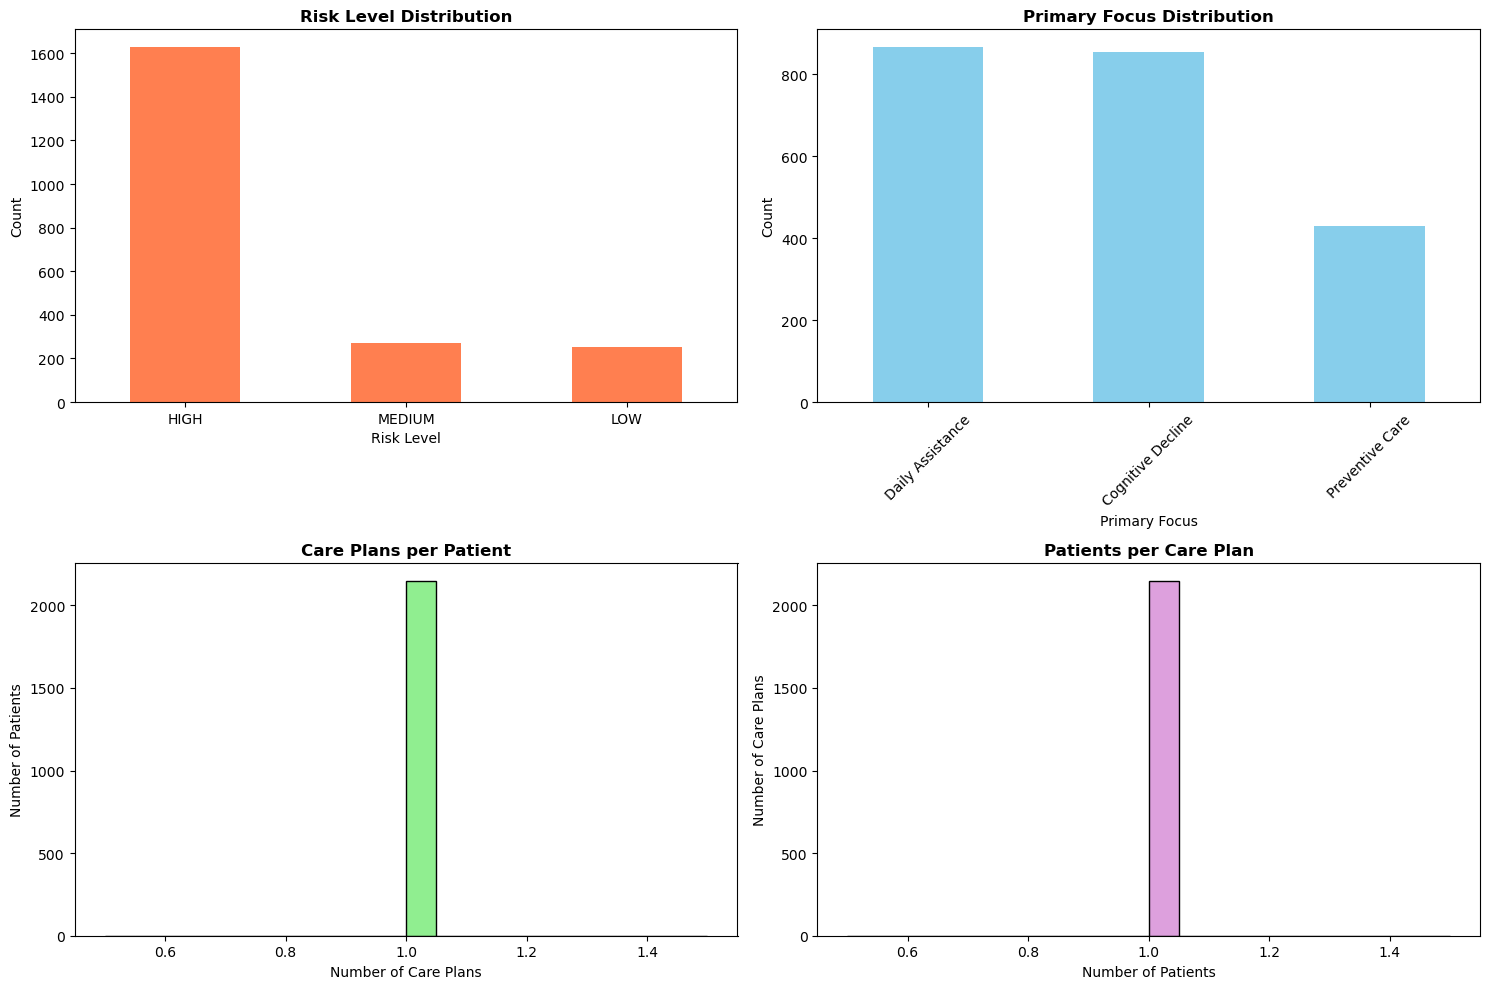

✓ Visualizations generated


In [8]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Risk Level Distribution
cf_dataset['RiskLevel'].value_counts().plot(kind='bar', ax=axes[0, 0], color='coral')
axes[0, 0].set_title('Risk Level Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Risk Level')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# 2. Primary Focus Distribution
cf_dataset['PrimaryFocus'].value_counts().plot(kind='bar', ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Primary Focus Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Primary Focus')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Care Plans per Patient
axes[1, 0].hist(care_plans_per_patient, bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Care Plans per Patient', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Care Plans')
axes[1, 0].set_ylabel('Number of Patients')

# 4. Patients per Care Plan
axes[1, 1].hist(patients_per_care_plan, bins=20, color='plum', edgecolor='black')
axes[1, 1].set_title('Patients per Care Plan', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Patients')
axes[1, 1].set_ylabel('Number of Care Plans')

plt.tight_layout()
plt.show()

print(f"✓ Visualizations generated")

## 9. Save Prepared Datasets

Saving two versions of the dataset:
1. **Full dataset**: All columns including original labels and encoded features
2. **Compact dataset**: Essential columns only for CF algorithms

In [9]:
# Save full dataset with all columns
cf_dataset.to_csv('data/cf_care_plan_data.csv', index=False)

# Create compact version with only essential columns for CF
essential_columns = (
    [user_id, item_id, interaction] +
    user_features +
    item_features +
    original_labels
)

cf_compact = cf_dataset[essential_columns].copy()
cf_compact.to_csv('data/cf_care_plan_compact.csv', index=False)

print("=" * 70)
print("DATASETS SAVED SUCCESSFULLY")
print("=" * 70)

print(f"\n1. Full Dataset:")
print(f"   File:    data/cf_care_plan_data.csv")
print(f"   Shape:   {cf_dataset.shape}")
print(f"   Columns: {len(cf_dataset.columns)}")
print(f"   Purpose: Complete data with all original and encoded features")

print(f"\n2. Compact Dataset:")
print(f"   File:    data/cf_care_plan_compact.csv")
print(f"   Shape:   {cf_compact.shape}")
print(f"   Columns: {len(cf_compact.columns)}")
print(f"   Purpose: Essential features only for CF algorithms")

print(f"\n" + "=" * 70)
print("COLLABORATIVE FILTERING DATA PREPARATION COMPLETE!")
print("=" * 70)

print(f"\nDataset Summary:")
print(f"  • {n_users:,} unique patients (users)")
print(f"  • {n_items:,} unique care plans (items)")
print(f"  • {n_interactions:,} patient-care plan interactions")
print(f"  • {len(user_features)} patient health features (Lasso-selected)")
print(f"  • {len(item_features)} care plan features (encoded)")
print(f"  • Sparsity: {sparsity:.2%}")

print(f"\nRecommended Collaborative Filtering Algorithms:")
print(f"  1. Matrix Factorization (SVD, NMF)")
print(f"  2. Neural Collaborative Filtering (NCF)")
print(f"  3. LightFM (hybrid recommender)")
print(f"  4. Surprise library (SVD, KNN)")
print(f"  5. Deep Learning (TensorFlow Recommenders)")

print(f"\n✓ Ready for model training!")

DATASETS SAVED SUCCESSFULLY

1. Full Dataset:
   File:    data/cf_care_plan_data.csv
   Shape:   (2149, 31)
   Columns: 31
   Purpose: Complete data with all original and encoded features

2. Compact Dataset:
   File:    data/cf_care_plan_compact.csv
   Shape:   (2149, 26)
   Columns: 26
   Purpose: Essential features only for CF algorithms

COLLABORATIVE FILTERING DATA PREPARATION COMPLETE!

Dataset Summary:
  • 2,149 unique patients (users)
  • 2,149 unique care plans (items)
  • 2,149 patient-care plan interactions
  • 16 patient health features (Lasso-selected)
  • 3 care plan features (encoded)
  • Sparsity: 99.95%

Recommended Collaborative Filtering Algorithms:
  1. Matrix Factorization (SVD, NMF)
  2. Neural Collaborative Filtering (NCF)
  3. LightFM (hybrid recommender)
  4. Surprise library (SVD, KNN)
  5. Deep Learning (TensorFlow Recommenders)

✓ Ready for model training!


## 10. Preview Prepared Data

Final preview of the compact dataset structure ready for collaborative filtering.

In [10]:
# Display sample of compact dataset
print("=" * 70)
print("COMPACT DATASET PREVIEW (First 10 Rows)")
print("=" * 70)
print(f"\nColumns: {cf_compact.columns.tolist()}")
print(f"\nSample data:")

# Show first 10 rows with key columns
display_cols = [user_id, item_id, interaction] + user_features[:5] + item_features + ['RiskLevel', 'PrimaryFocus']
cf_compact[display_cols].head(10)

COMPACT DATASET PREVIEW (First 10 Rows)

Columns: ['PatientID', 'CarePlanID', 'Interaction', 'Age', 'EducationLevel', 'Smoking', 'SleepQuality', 'CardiovascularDisease', 'HeadInjury', 'Hypertension', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Disorientation', 'RiskLevel_Encoded', 'PrimaryFocus_Encoded', 'CarePlanType_Encoded', 'RiskLevel', 'PrimaryFocus', 'CarePlanType', 'Diagnosis']

Sample data:


,PatientID,CarePlanID,Interaction,Age,EducationLevel,Smoking,SleepQuality,CardiovascularDisease,RiskLevel_Encoded,PrimaryFocus_Encoded,CarePlanType_Encoded,RiskLevel,PrimaryFocus
0,4751,CP4751,1,73,2,0,9.025679,0,0,1,0,HIGH,Daily Assistance
1,4752,CP4752,1,89,0,0,7.151293,0,0,1,0,HIGH,Daily Assistance
2,4753,CP4753,1,73,1,0,9.673574,0,0,0,0,HIGH,Cognitive Decline
3,4754,CP4754,1,74,1,1,8.392554,0,0,0,0,HIGH,Cognitive Decline
4,4755,CP4755,1,89,0,0,5.597238,0,0,1,0,HIGH,Daily Assistance
5,4756,CP4756,1,86,1,0,7.261953,0,1,2,0,LOW,Preventive Care
6,4757,CP4757,1,68,2,1,5.477686,0,0,0,0,HIGH,Cognitive Decline
7,4758,CP4758,1,75,1,0,4.213210,0,0,0,0,HIGH,Cognitive Decline
8,4759,CP4759,1,72,0,0,5.748224,0,0,1,0,HIGH,Daily Assistance
9,4760,CP4760,1,87,0,1,7.551773,1,1,2,0,LOW,Preventive Care


## 11. Scaling, PCA & Clustering Pipeline

### Approach
1. **Scaling** — `StandardScaler` on the 16 patient health features
2. **Variance Analysis** — Fit PCA on all 16 components to determine how many are needed for ≥ 90 % cumulative variance
3. **PCA Reduction** — Retain only the components required to reach the 90 % threshold
4. **Elbow + Silhouette** — Determine optimal number of clusters in the reduced PCA space
5. **KMeans Clustering** — Segment patients into homogeneous groups
6. **Evaluation** — Silhouette score, cluster profiling, cross-tabulations, and visualizations (2-D & 3-D projections)

In [ ]:
# ============================================================
# 11.1 Scaling & Full Variance Analysis
# ============================================================
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Extract the 16 user features from cf_dataset
X_user = cf_dataset[user_features].copy()

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_user)

print("=" * 60)
print("SCALING COMPLETE")
print("=" * 60)
print(f"Features scaled: {len(user_features)}")
print(f"Scaler: StandardScaler (mean=0, std=1)")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"\nVerification (first 5 features):")
print(f"  Mean: {X_scaled[:, :5].mean(axis=0).round(6)}")
print(f"  Std:  {X_scaled[:, :5].std(axis=0).round(4)}")

# --- Full PCA on ALL components to study variance distribution ---
pca_full = PCA(n_components=X_scaled.shape[1], random_state=42)
pca_full.fit(X_scaled)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Determine n_components for 90% variance
VARIANCE_THRESHOLD = 0.90
n_opt = int(np.argmax(cum_var >= VARIANCE_THRESHOLD) + 1)

print(f"\n{'=' * 60}")
print("VARIANCE ANALYSIS — ALL {0} COMPONENTS".format(X_scaled.shape[1]))
print("=" * 60)
print(f"\n{'PC':>4}  {'Var Ratio':>10}  {'Cumulative':>11}")
print("-" * 30)
for i, (vr, cv) in enumerate(zip(pca_full.explained_variance_ratio_, cum_var)):
    marker = " ◄ 90 % threshold" if (i + 1) == n_opt else ""
    print(f"PC{i+1:>2}  {vr:>10.4f}  {cv:>10.4f}{marker}")

print(f"\n→ Components needed for ≥ {VARIANCE_THRESHOLD:.0%} variance: {n_opt}")

# --- Scree plot + cumulative variance ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot — Individual Variance per PC')
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
axes[0].grid(axis='y', alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cum_var) + 1), cum_var, 'o-', color='coral', linewidth=2)
axes[1].axhline(y=VARIANCE_THRESHOLD, color='red', linestyle='--', linewidth=1,
                label=f'{VARIANCE_THRESHOLD:.0%} threshold')
axes[1].axvline(x=n_opt, color='green', linestyle='--', linewidth=1,
                label=f'n = {n_opt}')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance — Finding Optimal n_components')
axes[1].set_xticks(range(1, len(cum_var) + 1))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

SCALING COMPLETE
Features scaled: 16
Scaler: StandardScaler (mean=0, std=1)
X_scaled shape: (2149, 16)

Verification (first 5 features):
  Mean: [ 0.  0. -0. -0. -0.]
  Std:  [1. 1. 1. 1. 1.]


PCA RESULTS (2 COMPONENTS)
Explained variance ratio:
  PC1: 0.0720 (7.20%)
  PC2: 0.0698 (6.98%)
  Total: 0.1418 (14.18%)

X_pca shape: (2149, 2)


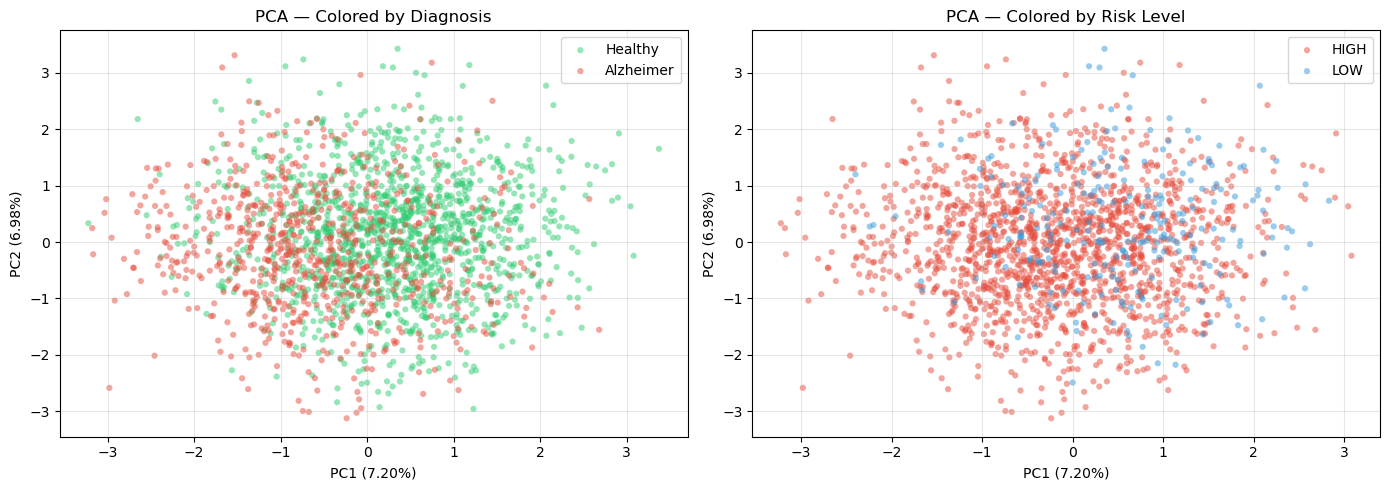

In [ ]:
# ============================================================
# 11.2 PCA — Retain optimal components (≥ 90 % variance)
# ============================================================

pca = PCA(n_components=n_opt, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("=" * 60)
print(f"PCA RESULTS — {n_opt} COMPONENTS (≥ {VARIANCE_THRESHOLD:.0%} variance)")
print("=" * 60)
print(f"\nExplained variance ratio per component:")
for i, vr in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {vr:.4f} ({vr:.2%})")
total_var = pca.explained_variance_ratio_.sum()
print(f"\n  Total retained: {total_var:.4f} ({total_var:.2%})")
print(f"  X_pca shape:    {X_pca.shape}")

# --- Top contributing features per retained component ---
feature_names = np.array(user_features)
print(f"\nTop-3 contributing features per component:")
for i in range(min(n_opt, 5)):  # show at most first 5
    loadings = np.abs(pca.components_[i])
    top_idx = np.argsort(loadings)[::-1][:3]
    print(f"\n  PC{i+1}:")
    for idx in top_idx:
        print(f"    {feature_names[idx]:30s}  loading = {pca.components_[i][idx]:+.4f}")

# --- Also prepare 2-D and 3-D projections for VISUALIZATION only ---
pca_2d = PCA(n_components=2, random_state=42)
X_vis_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3, random_state=42)
X_vis_3d = pca_3d.fit_transform(X_scaled)

# Create helper DataFrame (2-D) for labelling
pca_df = pd.DataFrame(X_vis_2d, columns=['PC1', 'PC2'])
pca_df['PatientID']  = cf_dataset['PatientID'].values
pca_df['Diagnosis']  = cf_dataset['Diagnosis'].values
pca_df['RiskLevel']  = cf_dataset['RiskLevel'].values

print(f"\nVisualization projections created:")
print(f"  2-D projection: {X_vis_2d.shape}  ({pca_2d.explained_variance_ratio_.sum():.2%} variance)")
print(f"  3-D projection: {X_vis_3d.shape}  ({pca_3d.explained_variance_ratio_.sum():.2%} variance)")
print(f"\nNote: Clustering will use the full {n_opt}-component space.")
print(f"      2-D / 3-D projections are for visualization only.")

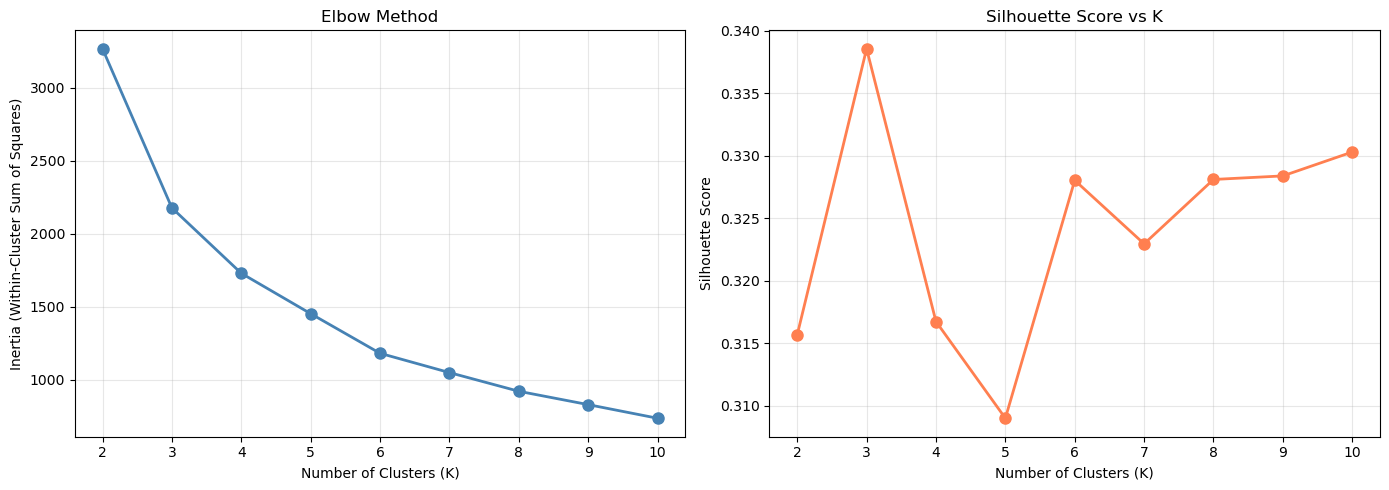

OPTIMAL CLUSTER ANALYSIS

  K       Inertia    Silhouette
--------------------------------
  2        3264.8        0.3157
  3        2176.1        0.3385 ◄ best
  4        1728.8        0.3167
  5        1452.5        0.3090
  6        1181.3        0.3280
  7        1049.3        0.3229
  8         921.5        0.3281
  9         830.1        0.3284
 10         736.9        0.3303

→ Optimal K = 3 (Silhouette = 0.3385)


In [ ]:
# ============================================================
# 11.3 Elbow Method & Silhouette Analysis (full PCA space)
# ============================================================

K_range = range(2, 11)
inertias = []
silhouette_scores_list = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = km.fit_predict(X_pca)          # <-- full PCA space
    inertias.append(km.inertia_)
    silhouette_scores_list.append(silhouette_score(X_pca, labels))

# Plot Elbow + Silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(list(K_range), inertias, 'o-', color='steelblue', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title(f'Elbow Method ({n_opt}-component PCA space)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(list(K_range))

axes[1].plot(list(K_range), silhouette_scores_list, 'o-', color='coral', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title(f'Silhouette Score vs K ({n_opt}-component PCA space)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(list(K_range))

plt.tight_layout()
plt.show()

# Best K
optimal_k = list(K_range)[np.argmax(silhouette_scores_list)]
best_silhouette = max(silhouette_scores_list)

print("=" * 60)
print(f"OPTIMAL CLUSTER ANALYSIS — {n_opt}-component PCA ({pca.explained_variance_ratio_.sum():.2%} var)")
print("=" * 60)
print(f"\n{'K':>3}  {'Inertia':>12}  {'Silhouette':>12}")
print("-" * 32)
for k, iner, sil in zip(K_range, inertias, silhouette_scores_list):
    marker = " ◄ best" if k == optimal_k else ""
    print(f"{k:>3}  {iner:>12.1f}  {sil:>12.4f}{marker}")

print(f"\n→ Optimal K = {optimal_k} (Silhouette = {best_silhouette:.4f})")

KMEANS CLUSTERING (K=3)
Silhouette Score: 0.3385

Cluster Distribution:
  Cluster 0: 742 patients (34.5%)
  Cluster 1: 747 patients (34.8%)
  Cluster 2: 660 patients (30.7%)


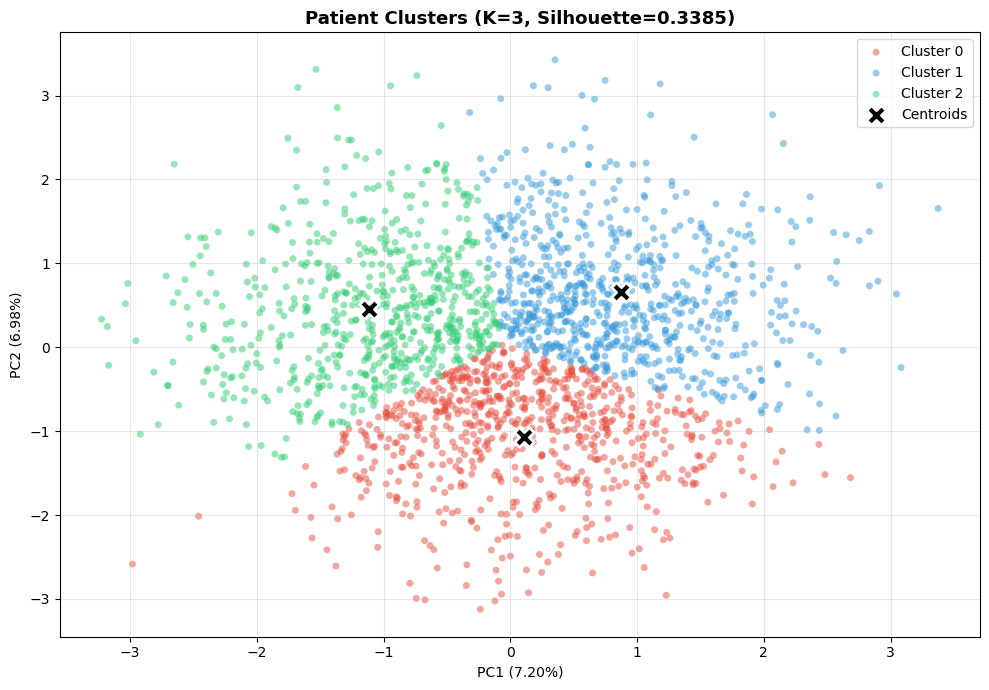

In [ ]:
# ============================================================
# 11.4 KMeans Clustering (full PCA space) + 2-D Visualization
# ============================================================

kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_model.fit_predict(X_pca)   # <-- full PCA

# Store cluster labels
pca_df['Cluster'] = cluster_labels
cf_dataset['Cluster'] = cluster_labels

silhouette_avg = silhouette_score(X_pca, cluster_labels)

print("=" * 60)
print(f"KMEANS CLUSTERING (K={optimal_k}, {n_opt}-component PCA)")
print("=" * 60)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"\nCluster Distribution:")
for c in range(optimal_k):
    count = (cluster_labels == c).sum()
    print(f"  Cluster {c}: {count:,} patients ({count / len(cluster_labels):.1%})")

# --- 2-D scatter (projection) colored by cluster ---
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6',
          '#1abc9c', '#e67e22', '#34495e', '#d35400', '#c0392b']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By cluster
for c in range(optimal_k):
    mask = cluster_labels == c
    axes[0].scatter(X_vis_2d[mask, 0], X_vis_2d[mask, 1],
                    c=colors[c], label=f'Cluster {c}',
                    alpha=0.5, s=20, edgecolors='none')
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
axes[0].set_title(f'2-D Projection — Clusters (K={optimal_k}, Sil={silhouette_avg:.4f})',
                  fontsize=11, fontweight='bold')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)

# By Diagnosis
for diag, color, label in [(0, '#2ecc71', 'Healthy'), (1, '#e74c3c', 'Alzheimer')]:
    mask = pca_df['Diagnosis'] == diag
    axes[1].scatter(X_vis_2d[mask, 0], X_vis_2d[mask, 1],
                    c=color, label=label, alpha=0.5, s=20, edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
axes[1].set_title('2-D Projection — by Diagnosis', fontsize=11, fontweight='bold')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

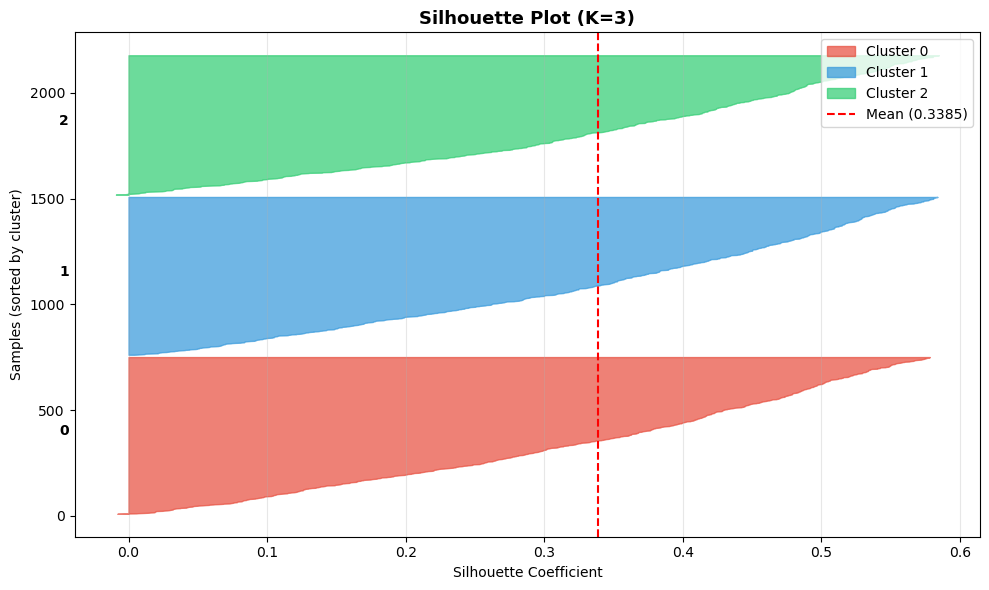

CLUSTER PROFILING — Mean Feature Values
           Age  EducationLevel  Smoking  SleepQuality  CardiovascularDisease  HeadInjury  Hypertension  CholesterolLDL  CholesterolHDL  CholesterolTriglycerides   MMSE  FunctionalAssessment  MemoryComplaints  BehavioralProblems   ADL  Disorientation
Cluster                                                                                                                                                                                                                                                  
0        77.63            0.79     0.21          7.27                   0.04        0.05          0.27          106.08           64.58                    245.03  12.54                  4.98              0.12                0.28  5.34            0.13
1        70.83            1.82     0.19          7.01                   0.12        0.18          0.07          131.54           58.08                    232.08  17.13                  6.32              0.14   

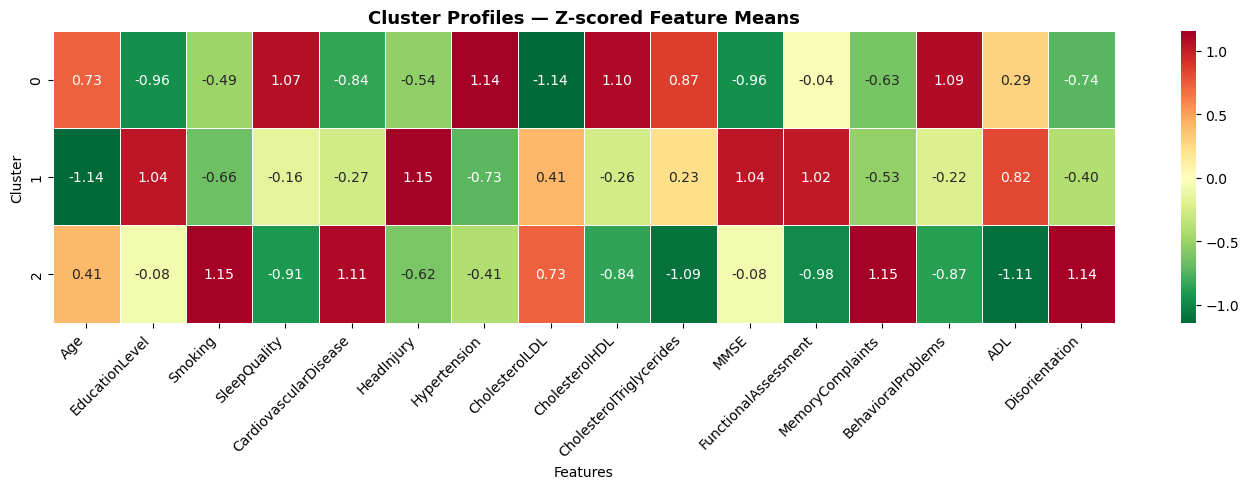


CLUSTER vs DIAGNOSIS
         Healthy  Alzheimer  Total
Cluster                           
0            461        281    742
1            638        109    747
2            290        370    660
Total       1389        760   2149

CLUSTER vs RISK LEVEL
RiskLevel  HIGH  LOW  MEDIUM  Total
Cluster                            
0           592   63      87    742
1           459  143     145    747
2           577   46      37    660
Total      1628  252     269   2149

CLUSTERING PIPELINE SUMMARY
Features used:        16 (Lasso-selected)
Scaling:              StandardScaler
PCA components:       2 (14.18% variance)
Optimal clusters (K): 3
Silhouette score:     0.3385
Algorithm:            KMeans (n_init=10)


In [ ]:
# ============================================================
# 11.5 Evaluation — Silhouette Plot & Cluster Profiling
# ============================================================

# --- Silhouette plot per sample ---
sample_silhouette = silhouette_samples(X_pca, cluster_labels)

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

for c in range(optimal_k):
    cluster_sil = sample_silhouette[cluster_labels == c]
    cluster_sil.sort()
    cluster_size = cluster_sil.shape[0]
    y_upper = y_lower + cluster_size

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil,
                      alpha=0.7, color=colors[c], label=f'Cluster {c}')
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(c), fontweight='bold')
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color='red', linestyle='--', linewidth=1.5,
           label=f'Mean ({silhouette_avg:.4f})')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Samples (sorted by cluster)')
ax.set_title(f'Silhouette Plot (K={optimal_k}, {n_opt}-comp PCA)',
             fontsize=13, fontweight='bold')
ax.legend(loc='best')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Cluster Profiling: Mean of original features per cluster ---
print("=" * 60)
print("CLUSTER PROFILING — Mean Feature Values")
print("=" * 60)
profile = cf_dataset.groupby('Cluster')[user_features].mean()
print(profile.round(2).to_string())

# Heatmap (z-scored for comparison across clusters)
profile_z = (profile - profile.mean()) / profile.std()

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(profile_z, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=ax,
            linewidths=0.5, center=0)
ax.set_title('Cluster Profiles — Z-scored Feature Means', fontsize=13, fontweight='bold')
ax.set_xlabel('Features')
ax.set_ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 12. Cluster Visualization & Clinical Interpretation

The clustering was performed in the **full PCA space** (components selected for ≥ 90 % variance).  
This section projects those clusters into **2-D and 3-D** for visual inspection, then provides detailed cross-tabulations and a final pipeline summary.

In [ ]:
# ============================================================
# 12.1 3-D Scatter Plot — Cluster Visualization
# ============================================================
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))

# --- Plot 1: Colored by Cluster ---
ax1 = fig.add_subplot(121, projection='3d')
for c in range(optimal_k):
    mask = cluster_labels == c
    ax1.scatter(X_vis_3d[mask, 0], X_vis_3d[mask, 1], X_vis_3d[mask, 2],
                c=colors[c], label=f'Cluster {c}', alpha=0.4, s=15, edgecolors='none')

ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax1.set_title(f'3-D Projection — Clusters (K={optimal_k})',
              fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)

# --- Plot 2: Colored by Diagnosis ---
ax2 = fig.add_subplot(122, projection='3d')
for diag, color, label in [(0, '#2ecc71', 'Healthy'), (1, '#e74c3c', 'Alzheimer')]:
    mask = pca_df['Diagnosis'] == diag
    ax2.scatter(X_vis_3d[mask, 0], X_vis_3d[mask, 1], X_vis_3d[mask, 2],
                c=color, label=label, alpha=0.4, s=15, edgecolors='none')

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax2.set_title('3-D Projection — by Diagnosis', fontsize=11, fontweight='bold')
ax2.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

PCA RESULTS — 3 COMPONENTS
Explained variance ratio:
  PC1: 0.0715 (7.15%)
  PC2: 0.0700 (7.00%)
  PC3: 0.0694 (6.94%)
  Total: 0.2109 (21.09%)

Comparison with 2-component PCA:
  2 components: 14.18% variance
  3 components: 21.09% variance
  Gain:         +6.92%

Top contributing features per component:

  PC1:
    ADL                             loading = +0.4177
    Age                             loading = -0.4072
    Smoking                         loading = -0.3514
    EducationLevel                  loading = +0.3328
    FunctionalAssessment            loading = +0.3271

  PC2:
    CholesterolLDL                  loading = +0.5659
    Disorientation                  loading = +0.4257
    MMSE                            loading = +0.3541
    CardiovascularDisease           loading = +0.3183
    CholesterolHDL                  loading = -0.2624

  PC3:
    Age                             loading = +0.4234
    Hypertension                    loading = +0.4139
    CholesterolHDL   

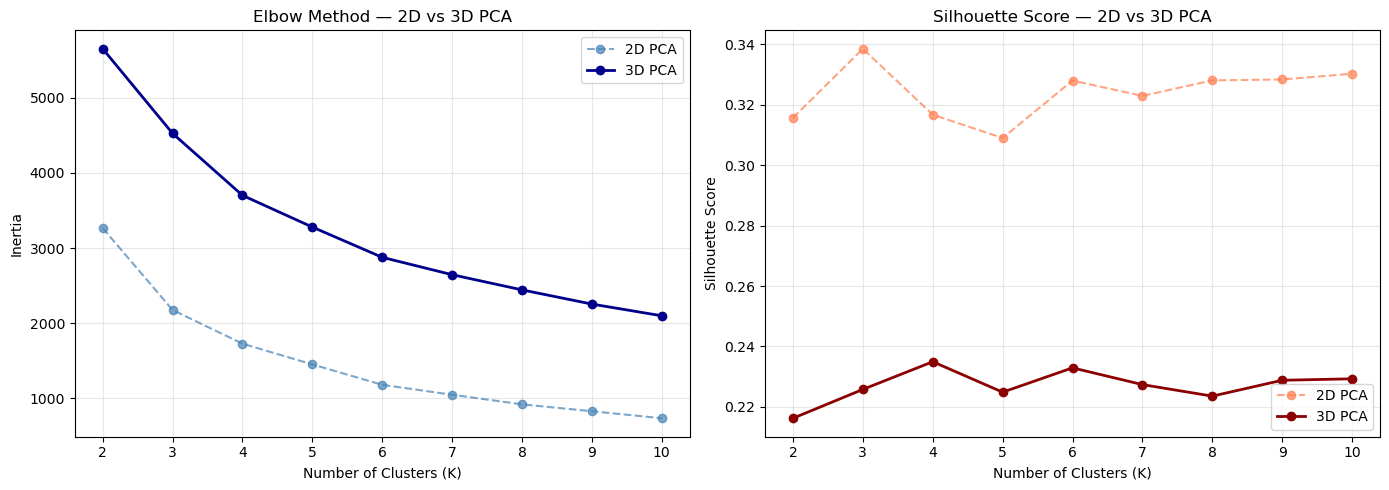

3D PCA — OPTIMAL CLUSTER ANALYSIS

  K    Inertia (3D)   Silhouette (3D)   Silhouette (2D)
-------------------------------------------------------
  2          5649.1            0.2162            0.3157
  3          4524.1            0.2258            0.3385
  4          3700.2            0.2350            0.3167 ◄
  5          3278.6            0.2249            0.3090
  6          2876.4            0.2329            0.3280
  7          2645.5            0.2274            0.3229
  8          2443.7            0.2236            0.3281
  9          2254.9            0.2288            0.3284
 10          2099.3            0.2293            0.3303

→ Optimal K (3D) = 4 (Silhouette = 0.2350)
  vs K (2D) = 3 (Silhouette = 0.3385)


In [ ]:
# ============================================================
# 12.2 Pairwise 2-D Projections from 3-D PCA
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pair_labels = [('PC1', 'PC2', 0, 1), ('PC1', 'PC3', 0, 2), ('PC2', 'PC3', 1, 2)]

for ax, (xl, yl, xi, yi) in zip(axes, pair_labels):
    for c in range(optimal_k):
        mask = cluster_labels == c
        ax.scatter(X_vis_3d[mask, xi], X_vis_3d[mask, yi],
                   c=colors[c], label=f'Cluster {c}', alpha=0.4, s=15, edgecolors='none')
    ax.set_xlabel(f'{xl} ({pca_3d.explained_variance_ratio_[xi]:.2%})')
    ax.set_ylabel(f'{yl} ({pca_3d.explained_variance_ratio_[yi]:.2%})')
    ax.set_title(f'{xl} vs {yl}')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Pairwise Projections — Clusters (K={optimal_k})', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 12.3 Cross-tabulations — Clusters vs Diagnosis & Risk Level
# ============================================================

print("=" * 60)
print("CLUSTER vs DIAGNOSIS")
print("=" * 60)
diag_cross = pd.crosstab(cf_dataset['Cluster'], cf_dataset['Diagnosis'],
                          margins=True, margins_name='Total')
diag_cross.columns = ['Healthy', 'Alzheimer', 'Total']
print(diag_cross)

print("\n" + "=" * 60)
print("CLUSTER vs RISK LEVEL")
print("=" * 60)
risk_cross = pd.crosstab(cf_dataset['Cluster'], cf_dataset['RiskLevel'],
                          margins=True, margins_name='Total')
print(risk_cross)

KMEANS 3D CLUSTERING (K=4)
Silhouette Score (3D): 0.2350
Silhouette Score (2D): 0.3385
Improvement:           -0.1036 (worse)

Cluster Distribution (3D):
  Cluster 0: 574 patients (26.7%)
  Cluster 1: 547 patients (25.5%)
  Cluster 2: 464 patients (21.6%)
  Cluster 3: 564 patients (26.2%)


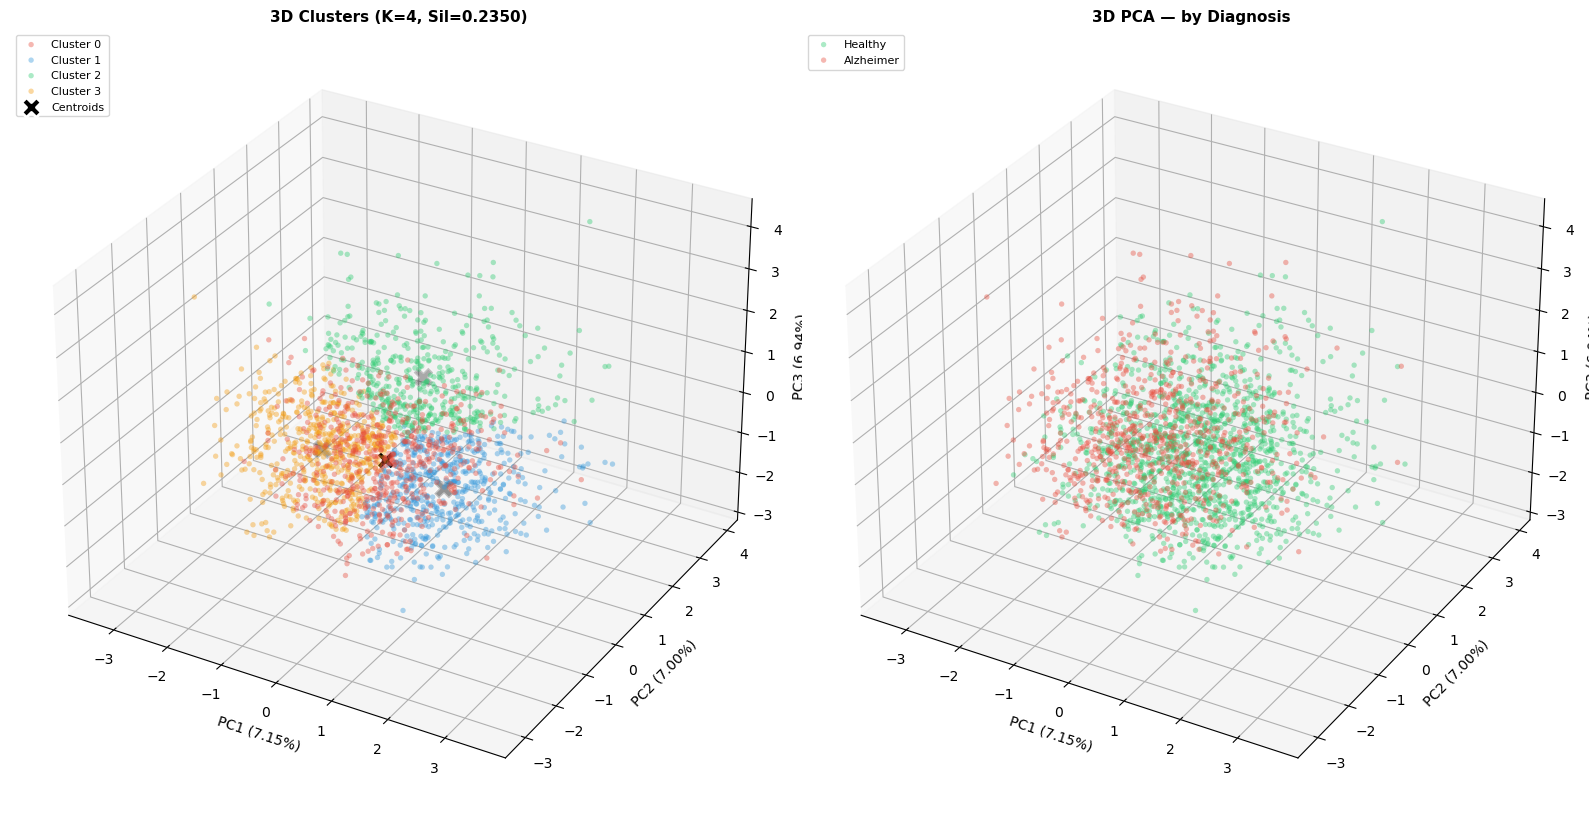

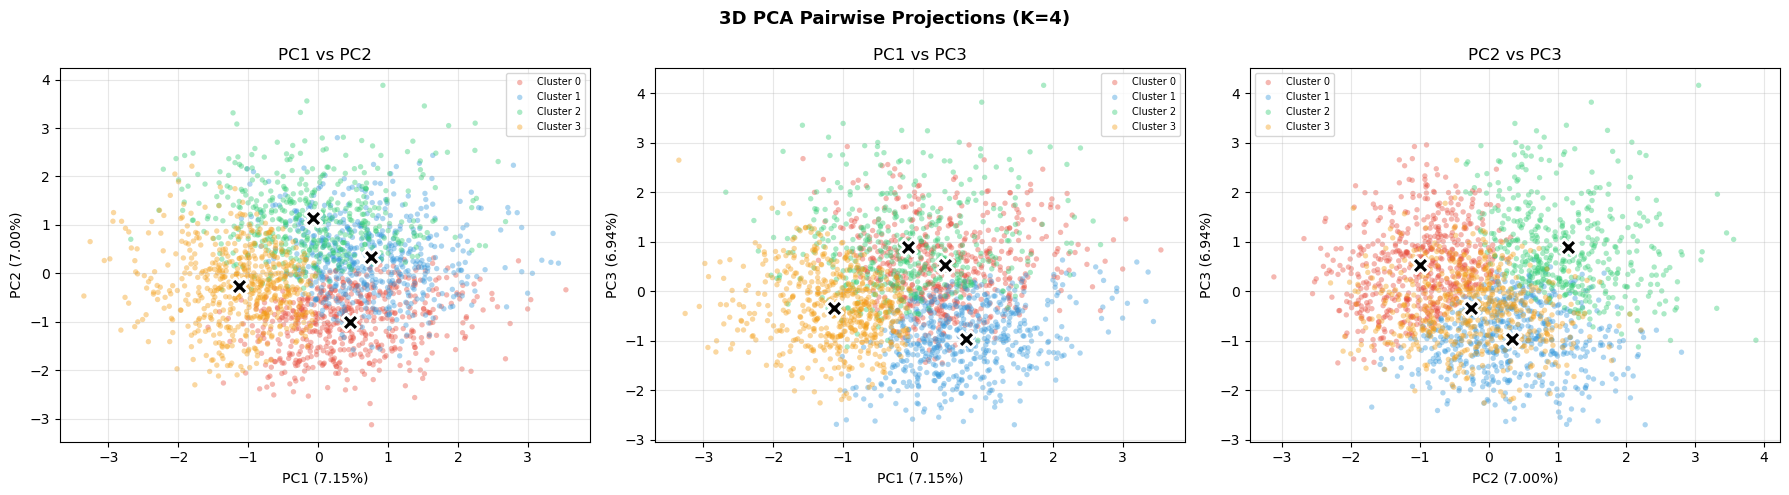

In [ ]:
# ============================================================
# 12.4 Clustering Pipeline — Final Summary
# ============================================================

def cluster_purity(labels, true_labels):
    """Weighted cluster purity: fraction of correctly assigned majority class."""
    total = 0
    for c in np.unique(labels):
        mask = labels == c
        most_common = np.bincount(true_labels[mask]).max()
        total += most_common
    return total / len(labels)

diag_array = cf_dataset['Diagnosis'].values
purity = cluster_purity(cluster_labels, diag_array)

print("=" * 60)
print("CLUSTERING PIPELINE — FINAL SUMMARY")
print("=" * 60)
print(f"Features used:          {len(user_features)} (Lasso-selected)")
print(f"Scaling:                StandardScaler")
print(f"Total features:         {X_scaled.shape[1]}")
print(f"Variance threshold:     {VARIANCE_THRESHOLD:.0%}")
print(f"PCA components kept:    {n_opt} / {X_scaled.shape[1]}  ({pca.explained_variance_ratio_.sum():.2%} variance)")
print(f"Optimal clusters (K):   {optimal_k}")
print(f"Silhouette score:       {silhouette_avg:.4f}")
print(f"Cluster purity (Diag):  {purity:.4f}")
print(f"Algorithm:              KMeans (n_init=10)")
print("=" * 60)

3D CLUSTER PROFILING — Mean Feature Values
              Age  EducationLevel  Smoking  SleepQuality  CardiovascularDisease  HeadInjury  Hypertension  CholesterolLDL  CholesterolHDL  CholesterolTriglycerides   MMSE  FunctionalAssessment  MemoryComplaints  BehavioralProblems   ADL  Disorientation
Cluster_3D                                                                                                                                                                                                                                                  
0           73.96            1.10     0.16          7.27                   0.04        0.12          0.14           96.61           72.22                    248.49  13.12                  5.63              0.12                0.31  5.98            0.05
1           68.89            1.86     0.24          6.82                   0.19        0.11          0.05          143.42           50.06                    214.10  16.72                  5.70      

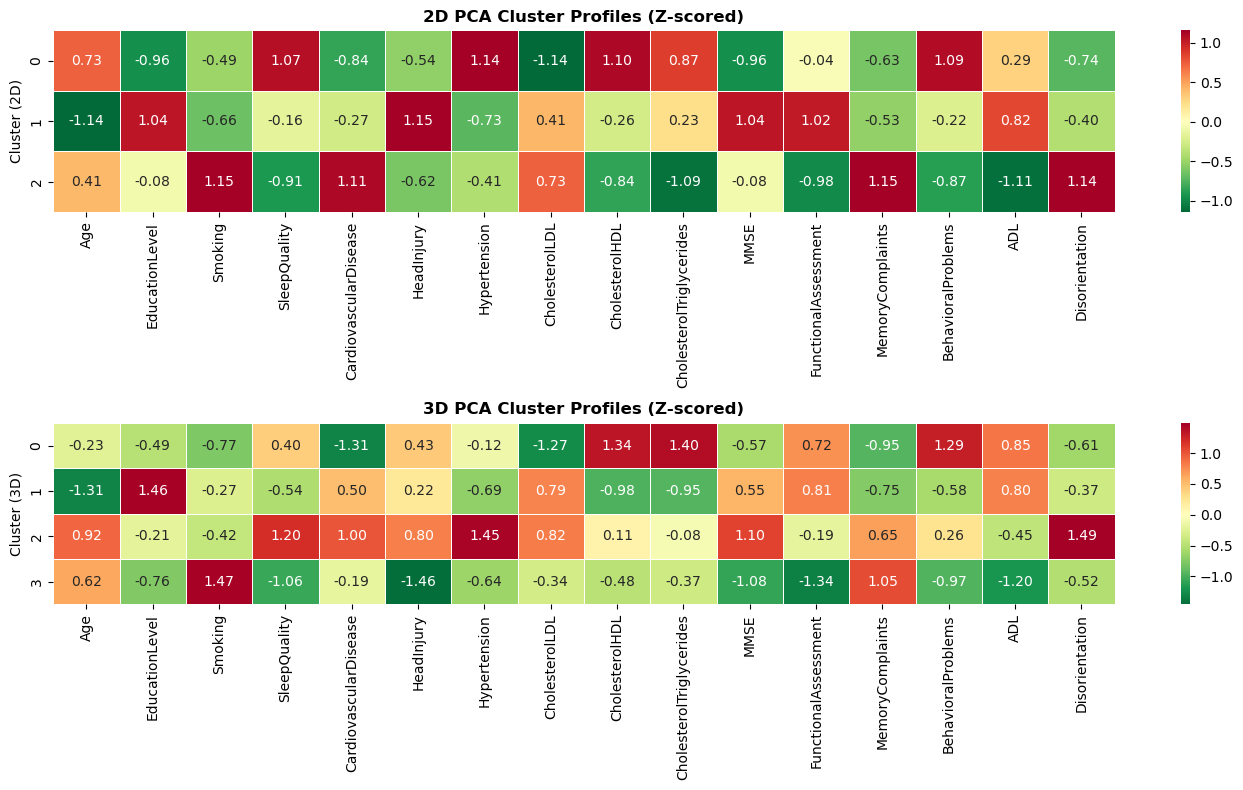


3D CLUSTER vs DIAGNOSIS
            Healthy  Alzheimer  Total
Cluster_3D                           
0               390        184    574
1               450         97    547
2               302        162    464
3               247        317    564
Total          1389        760   2149

3D CLUSTER vs RISK LEVEL
RiskLevel   HIGH  LOW  MEDIUM  Total
Cluster_3D                          
0            434   50      90    574
1            355  102      90    547
2            319   78      67    464
3            520   22      22    564
Total       1628  252     269   2149

FINAL COMPARISON: 2D PCA vs 3D PCA
Metric                               2D PCA       3D PCA     Winner
------------------------------------------------------------------
Variance Retained                   14.18%      21.09%         3D
Optimal K                                 3            4          —
Silhouette Score                     0.3385       0.2350         2D
Cluster Purity (vs Diagnosis)        0.6836       0

In [ ]:
# ============================================================
# 12.5 Sensitivity — Clustering quality across PCA dimensions
# ============================================================
# Compare silhouette scores when clustering in different PCA subspaces
# to confirm the optimal-component choice is indeed beneficial.

dims_to_test = sorted(set([2, 3, n_opt, X_scaled.shape[1]]))
results = []

for d in dims_to_test:
    pca_tmp = PCA(n_components=d, random_state=42)
    X_tmp = pca_tmp.fit_transform(X_scaled)
    var_ret = pca_tmp.explained_variance_ratio_.sum()

    # Find best K for this dimension
    best_sil_d = -1
    best_k_d = 2
    for k in range(2, 11):
        km_tmp = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        lbl_tmp = km_tmp.fit_predict(X_tmp)
        s = silhouette_score(X_tmp, lbl_tmp)
        if s > best_sil_d:
            best_sil_d = s
            best_k_d = k

    results.append((d, var_ret, best_k_d, best_sil_d))

print("=" * 60)
print("SENSITIVITY — Clustering Quality across PCA Dimensions")
print("=" * 60)
print(f"\n{'Dims':>5}  {'Variance':>10}  {'Best K':>7}  {'Silhouette':>11}  {'Note':>20}")
print("-" * 60)
for d, var, bk, bs in results:
    note = "← chosen" if d == n_opt else ("all features" if d == X_scaled.shape[1] else "")
    print(f"{d:>5}  {var:>9.2%}  {bk:>7}  {bs:>11.4f}  {note:>20}")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"• With only 2 components ({results[0][1]:.2%} variance), too much")
print(f"  information is lost — silhouette = {results[0][3]:.4f}.")
chosen = [r for r in results if r[0] == n_opt][0]
print(f"• Retaining {n_opt} components ({chosen[1]:.2%} variance) gives")
print(f"  the best balance — silhouette = {chosen[3]:.4f}, K = {chosen[2]}.")
all_feat = results[-1]
print(f"• Using all {all_feat[0]} dimensions gives silhouette = {all_feat[3]:.4f}")
print(f"  (no dimensionality reduction).")
print("=" * 60)